# Monte Carlo Simulation of Transport for Sr-II

In [1]:
import jax
import jax.numpy as jnp 
from jax import random, vmap, jit, lax
import diffrax
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# for animations in Jupyter notebooks
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

from dataclasses import dataclass, field
from collections import defaultdict

import pandas as pd

In [2]:

@dataclass
class LatticeExperiment:
    # --- Input parameters ---
    laser_lambda: float = 532e-9
    sr_mass: float = 1.44316060e-25
    U0_uK: float = 100
    sr_temp_uK: float = 5

    # --- Physical constants ---
    k_boltzmann: float = 1.380649e-23

    # --- Simulation defaults ---
    num_particles: int = None       # default number of particles
    # T_tilde: float = None           # dimensionless temperature

    # --- Derived quantities ---
    k: float = field(init=False)
    sr_energy_J: float = field(init=False)
    U0_J: float = field(init=False)
    Tc: float = field(init=False)
    Lc: float = field(init=False)
    T_tilde: float = field(init=False)  # dimensionless temperature

    def __post_init__(self):

        self.k = 2 * jnp.pi / self.laser_lambda
        self.sr_energy_J = (self.sr_temp_uK * 1e-6) * self.k_boltzmann
        self.U0_J = (self.U0_uK * 1e-6) * self.k_boltzmann
        self.Tc = jnp.sqrt(self.sr_mass / (self.U0_J * self.k**2)) * 1e9
        self.Lc = (1 / self.k) * 1e9

        self.T_tilde = self.sr_temp_uK / self.U0_uK # dimensionless temperature

        # default number of particles
        if self.num_particles is None:
            self.num_particles = 1000



In [3]:
exp = LatticeExperiment(num_particles=2000)

print("Wavevector k =", exp.k)
print("Lattice depth [uK] =", exp.U0_uK)
print("Characteristic time [ns] =", exp.Tc)
print("Characteristic length [nm] =", exp.Lc)
print("Number of particles =", exp.num_particles)
print('Dimensionless Temperature = ', exp.T_tilde)


Wavevector k = 11810498.697705988
Lattice depth [uK] = 100
Characteristic time [ns] = 865.66016
Characteristic length [nm] = 84.67042972488834
Number of particles = 2000
Dimensionless Temperature =  0.05


In [4]:

class InitialStateVectorSampler:
    """Sampler for initial dimensionless positions and velocities in a lattice."""

    def __init__(self, exp: LatticeExperiment, metropolis_steps: int = 1000):
        self.exp = exp
        self.metropolis_steps = metropolis_steps

    def sample_velocity(self, key):
        """Dimensionless velocity sampling: v_tilde ~ sqrt(T_tilde) * N(0,1)"""
        v_tilde = jnp.sqrt(self.exp.T_tilde) * random.normal(key, (self.exp.num_particles,))
        return v_tilde

    def sample_position_metropolis(self, key, step_size=0.1):
        """Metropolis sampler for dimensionless positions y_tilde using lax.fori_loop"""
        # Initialize y_tilde randomly
        y_tilde = (random.uniform(key, (self.exp.num_particles,)) - 0.5) * jnp.pi

        # Define one Metropolis step
        def metropolis_step(i, carry):
            y_tilde, key = carry
            key, subkey1, subkey2 = random.split(key, 3)

            # Propose new positions
            proposals = y_tilde + step_size * (random.uniform(subkey1, (self.exp.num_particles,)) - 0.5)
            proposals = jnp.clip(proposals, -jnp.pi/2, jnp.pi/2)

            # Compute potential energy differences
            old_potential = -0.5 * jnp.cos(2 * y_tilde)
            new_potential = -0.5 * jnp.cos(2 * proposals)
            delta_potential = new_potential - old_potential

            # Metropolis acceptance
            accept_prob = jnp.minimum(1.0, jnp.exp(-delta_potential / self.exp.T_tilde))
            accept = random.uniform(subkey2, (self.exp.num_particles,)) < accept_prob

            # Update positions
            y_tilde = jnp.where(accept, proposals, y_tilde)

            return y_tilde, key

        # Run Metropolis steps efficiently with lax.fori_loop
        y_tilde, key = lax.fori_loop(0, self.metropolis_steps, metropolis_step, (y_tilde, key))
        return y_tilde, key

    def sample(self, key):
        """Return a state vector (num_particles, 2): [y_tilde, v_tilde]"""
        key1, key2 = random.split(key)
        y_tilde, key1 = self.sample_position_metropolis(key1)
        v_tilde = self.sample_velocity(key2)
        state = jnp.stack([y_tilde, v_tilde], axis=1)
        return state, key1


In [8]:
# and we test it

key = random.PRNGKey(10)
experiment_sampler = InitialStateVectorSampler(exp)

jit_sample_state_vectors = jit(experiment_sampler.sample)  # top-level JIT

state_vectors, key = jit_sample_state_vectors(key)

Position range: [-0.570, 0.582]
Velocity mean: 0.0021, std: 0.2207
Expected velocity std: 0.2236


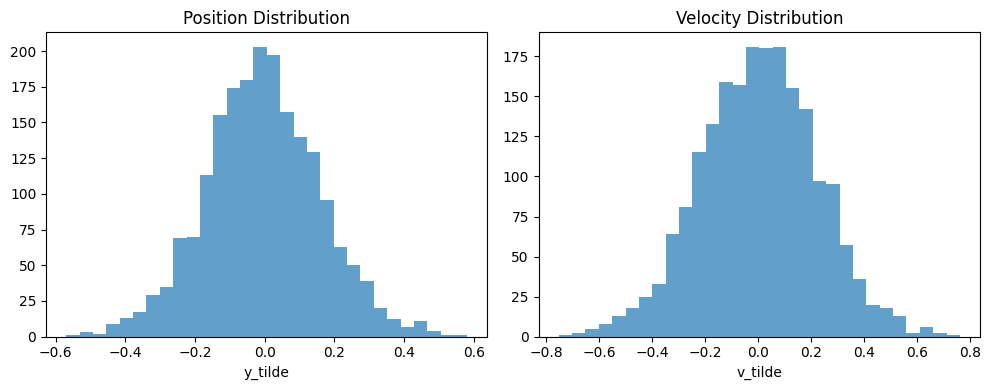

In [9]:
y_tilde = state_vectors[:,0]
v_tilde = state_vectors[:,1]

print(f"Position range: [{jnp.min(y_tilde):.3f}, {jnp.max(y_tilde):.3f}]")
print(f"Velocity mean: {jnp.mean(v_tilde):.4f}, std: {jnp.std(v_tilde):.4f}")
print(f"Expected velocity std: {jnp.sqrt(exp.T_tilde):.4f}")

# Quick plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.hist(y_tilde, bins=30, alpha=0.7)
ax1.set_xlabel('y_tilde')
ax1.set_title('Position Distribution')

ax2.hist(v_tilde, bins=30, alpha=0.7)
ax2.set_xlabel('v_tilde')
ax2.set_title('Velocity Distribution')

plt.tight_layout()
plt.show()

In [10]:

kinetic = 0.5 * v_tilde**2
potential = -0.5 * jnp.cos(2 * y_tilde)
total_energy = kinetic + potential

# Most should be trapped (E < 0)
trapped_fraction = jnp.mean(total_energy < 0)
print(f"Trapped fraction: {trapped_fraction:.2f}")

Trapped fraction: 1.00


In [ ]:
class LatticeTransportSimulator:

    def x(self, tau, T, gamma, L):
        t = tau / T
        coeffs = L * jnp.asarray([
            -24 + 16*gamma,
            60 - 40*gamma,
            -50 + 32*gamma,
            15 - 8*gamma,
            0,
            0
        ])
        return jnp.polyval(coeffs, t)

    def v(self, tau, T, gamma, L):
        return jax.grad(self.x, argnums=0)(tau, T, gamma, L)

    def a(self, tau, T, gamma, L):
        return jax.grad(self.v, argnums=0)(tau, T, gamma, L)

    def simulate_transport(self, state_vector, T, L, gamma, t0=0.0, num_steps=1000):

        def rhs(tau, state_vector, args):
            gamma, L, T = args
            y_tilde, v_tilde = state_vector
            dydtau = v_tilde
            dvdtau = -jnp.sin(2 * y_tilde) - 0.5 * self.a(tau, T, gamma, L)
            return jnp.array([dydtau, dvdtau])

        solver = diffrax.Tsit5()
        saveat = diffrax.SaveAt(ts=jnp.linspace(t0, T, num_steps))

        sol = diffrax.diffeqsolve(
            diffrax.ODETerm(rhs),
            solver,
            t0=t0,
            t1=T,
            dt0=0.01,
            y0=state_vector,
            args=(gamma, L, T),
            saveat=saveat,
            max_steps=10_000
        )

        return sol
    


    

In [15]:
# and we define some functions to help with the analysis

@jit
def check_trapped_batch(solutions):
    """Check if particles stay within well boundaries throughout simulation"""
    # Extract all position trajectories: shape (num_particles, num_timepoints)
    all_positions = solutions.ys[:, :, 0]
    
    # Check if each particle ever exceeds the well boundary
    max_displacement = jnp.max(jnp.abs(all_positions), axis=1)  # Max |y| for each particle
    
    # Particle is trapped if it never exceeds π/2
    trapped = max_displacement < jnp.pi/2

    # return boolean array indicating trapped status for each particle
    return trapped

@jit
def calculate_final_temperature(solutions, trapped_mask):
    """Calculate effective temperature from final velocity distribution"""
    # Get final velocities of ALL particles
    all_final_velocities = solutions.ys[:, -1, 1]  # Last timepoint, velocity component
    
    # Use jnp.where to filter trapped particles (JAX-compatible)
    final_velocities = jnp.where(trapped_mask, all_final_velocities, 0.0)
    
    # Only calculate variance for actually trapped particles
    num_trapped = jnp.sum(trapped_mask)
    
    # Calculate mean and variance manually for trapped particles only
    trapped_sum = jnp.sum(final_velocities)
    trapped_mean = trapped_sum / num_trapped
    
    # Variance calculation
    squared_deviations = jnp.where(trapped_mask, (all_final_velocities - trapped_mean)**2, 0.0)
    velocity_variance = jnp.sum(squared_deviations) / num_trapped
    
    return velocity_variance, all_final_velocities


@jit
def analyze_results(solutions):

    # Count trapped particles
    trapped_status = check_trapped_batch(solutions)
    trapped_count = jnp.sum(trapped_status)
    total_particles = len(trapped_status)
    efficiency = trapped_count / total_particles

    # Final temperatures / velocities
    T_final_dimensionless, final_velocities = calculate_final_temperature(solutions, trapped_status)

    delta_T = T_final_dimensionless - exp.T_tilde

    absolute_delta_T = delta_T * exp.U0_J / exp.k_boltzmann
    

    return total_particles, trapped_status, trapped_count, efficiency, final_velocities, T_final_dimensionless, delta_T, absolute_delta_T




In [21]:
# we vectorize the solver to parallelize the operations over the input state_vectors array

sim = LatticeTransportSimulator()

vectorized_simulate_transport = jax.jit(jax.vmap(
    sim.simulate_transport,
    in_axes=(0, None, None, None)  
    # state_vector batched, others shared
))


# And we test for some initial $T$, $L$, $\gamma$ to check


solutions = vectorized_simulate_transport(state_vectors, 10, 30, 1.5625)


# And we analyze
total_particles, trapped_status, trapped_count, efficiency, final_velocities, T_final_dimensionless, delta_T, absolute_delta_T = analyze_results(solutions)

print(f"\tTrapped particles: {trapped_count}/{total_particles} ({efficiency*100:.2f}%)")
print(f"\tFinal dimensionless temperature T_final_tilde: {T_final_dimensionless:.4f}")
print(f"\tChange in dimensionless temperature ΔT_tilde: {delta_T:.4f}")
print(f"\tAbsolute change in temperature ΔT: {absolute_delta_T*1e6} uK")


	Trapped particles: 1340/2000 (67.00%)
	Final dimensionless temperature T_final_tilde: 0.0634
	Change in dimensionless temperature ΔT_tilde: 0.0134
	Absolute change in temperature ΔT: 1.3426859378814697 uK


Nice, so the code is working. Now lets understand what the necessary $L$ and $T$ parameters are to achieve decent inertial transport speeds

In [23]:
total_transport_distance = 2 # in meters

total_transport_distance_dimensionless = 2/(exp.Lc*1e-9) # 2 meters divided by Lc in meters (to calculate the distance in units of critical length)

print(total_transport_distance_dimensionless)


23620997.395411972


We choose the zero jerk trajectory

$$
\gamma = 1.5625
$$

And we probably want to accelerate somewhere in the miliseconds range, so we calculate the equivalent dimensionless $T$

In [34]:
acceleration_time_scale = 1 # in ms (miliseconds)

dimensionless_time_scale = acceleration_time_scale / (exp.Tc * 1e-6) # exp.Tc is in ns (nanoseconds)

print(dimensionless_time_scale)

1155.1877


In [35]:
gamma = 1.5625

L_vals = jnp.logspace(2, 6, 50)
T_vals = jnp.linspace(1000, 10_000, 50)

# Allocate result array
time_ms = jnp.zeros((len(L_vals), len(T_vals)))


for i, L in enumerate(L_vals):
    for j, T in enumerate(T_vals):
        dimensionless_inertial_transport_time = total_transport_distance_dimensionless / sim.v(T/2, T, gamma, L)
        # time_ms = dimensionless_inertial_transport_time *   # replace exp.Tc with correct value
        time_ms = time_ms.at[i, j].set(dimensionless_inertial_transport_time * exp.Tc * 1e-6) # time in miliseconds

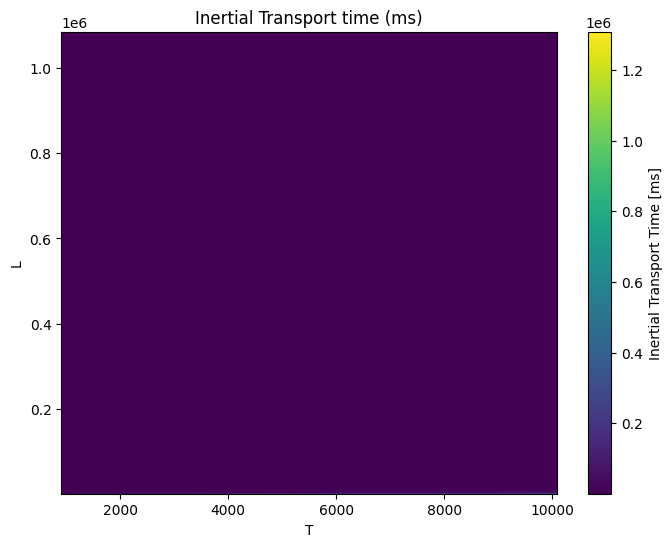

In [36]:
plt.figure(figsize=(8, 6))
plt.pcolormesh(T_vals, L_vals, time_ms, shading="auto", cmap="viridis")
plt.colorbar(label="Inertial Transport Time [ms]")
# plt.xscale("log")
# plt.yscale("log")
plt.xlabel("T")
plt.ylabel("L")
plt.title("Inertial Transport time (ms)")
plt.show()

In [ ]:
gamma = 1.5625

# Create grids
L_vals = jnp.logspace(2, 2, 50)
T_vals = jnp.linspace(1, 60, 50)


# Allocate result array
# time_ms = jnp.zeros((len(L_vals), len(T_vals)))
efficiencies = jnp.zeros((len(L_vals), len(T_vals)))
final_dts = jnp.zeros((len(L_vals), len(T_vals)))
final_dts_dimensionless = jnp.zeros((len(L_vals), len(T_vals)))

for i, L in enumerate(L_vals):
    for j, T in enumerate(T_vals):
        # dimensionless_inertial_transport_time = total_transport_length / sim.v(T/2, T, gamma, L)
        # time_ms = dimensionless_inertial_transport_time *   # replace exp.Tc with correct value
        # time_ms = time_ms.at[i, j].set(dimensionless_inertial_transport_time * exp.Tc * 1e-6)

        solutions = vectorized_simulate_transport(state_vectors, T, L, gamma)


# And we analyze
total_particles, trapped_status, trapped_count, efficiency, final_velocities, T_final_dimensionless, delta_T, absolute_delta_T = analyze_results(solutions)

        

In [12]:
# Logspace scan
Ls = jnp.logspace(-2,1, 30)
Ts = jnp.linspace(1,20, 20)
gamma = 1.5625

key = random.PRNGKey(0)

# Nested defaultdict for automatic creation
results = defaultdict(lambda: defaultdict(dict))
records = []  # pandas DataFrame records for summaries

for L in Ls:
    for T in Ts:

        print(f'Trying transport parameters L = {L}, T = {T}, gamma = {gamma}')

        state_vectors, key = jit_sample_state_vectors(key)
        
        solutions = vectorized_simulate_transport(state_vectors, T, L, gamma)

        # Count trapped particles
        trapped_status = check_trapped_batch(solutions)
        trapped_count = jnp.sum(trapped_status)
        total_particles = len(trapped_status)
        efficiency = trapped_count / total_particles

        print(f"\tTrapped particles: {trapped_count}/{total_particles} ({efficiency*100:.2f}%)")

        # Final temperatures / velocities
        T_final_dimensionless, final_velocities = calculate_final_temperature(solutions, trapped_status)

        print(f"\tFinal dimensionless temperature T_final_tilde: {T_final_dimensionless:.4f}")

        delta_T = T_final_dimensionless - exp.T_tilde
        print(f"\tChange in dimensionless temperature ΔT_tilde: {delta_T:.4f}")

        absolute_delta_T = delta_T * exp.U0_J / exp.k_boltzmann
        print(f"\tAbsolute change in temperature ΔT: {absolute_delta_T*1e6} uK")

        # -----------------------------
        # Store in nested defaultdict
        # -----------------------------
        L_key = round(float(L),6)
        T_key = round(float(T),6)
        gamma_key = round(float(gamma),6)

        results[L_key][T_key][gamma_key] = {
            'solutions': solutions,
            'trapped_status': trapped_status,
            'trapped_count': trapped_count,
            'total_particles': total_particles,
            'efficiency': efficiency,
            'final_velocities': final_velocities,
            'T_final_dimensionless': T_final_dimensionless,
            'delta_T': delta_T,
            'absolute_delta_T': absolute_delta_T
        }

        # -----------------------------
        # Store summary in pandas DataFrame
        # -----------------------------
        records.append({
            'L': L_key,
            'T': T_key,
            'gamma': gamma_key,
            'trapped_count': int(trapped_count),
            'total_particles': int(total_particles),
            'efficiency': efficiency,
            'T_final_tilde': T_final_dimensionless,
            'delta_T_tilde': delta_T,
            'absolute_delta_T_uK': absolute_delta_T*1e6
        })

# Build the summary DataFrame
df_results = pd.DataFrame(records)


Trying transport parameters L = 0.009999999776482582, T = 1.0, gamma = 1.5625
	Trapped particles: 2000/2000 (100.00%)
	Final dimensionless temperature T_final_tilde: 0.0520
	Change in dimensionless temperature ΔT_tilde: 0.0020
	Absolute change in temperature ΔT: 0.20379459857940674 uK
Trying transport parameters L = 0.009999999776482582, T = 2.0, gamma = 1.5625
	Trapped particles: 2000/2000 (100.00%)
	Final dimensionless temperature T_final_tilde: 0.0491
	Change in dimensionless temperature ΔT_tilde: -0.0009
	Absolute change in temperature ΔT: -0.09359531104564667 uK
Trying transport parameters L = 0.009999999776482582, T = 3.0, gamma = 1.5625
	Trapped particles: 2000/2000 (100.00%)
	Final dimensionless temperature T_final_tilde: 0.0506
	Change in dimensionless temperature ΔT_tilde: 0.0006
	Absolute change in temperature ΔT: 0.06189905107021332 uK
Trying transport parameters L = 0.009999999776482582, T = 4.0, gamma = 1.5625
	Trapped particles: 2000/2000 (100.00%)
	Final dimensionless t

In [35]:

array_entries = [20,22,24,26,28]

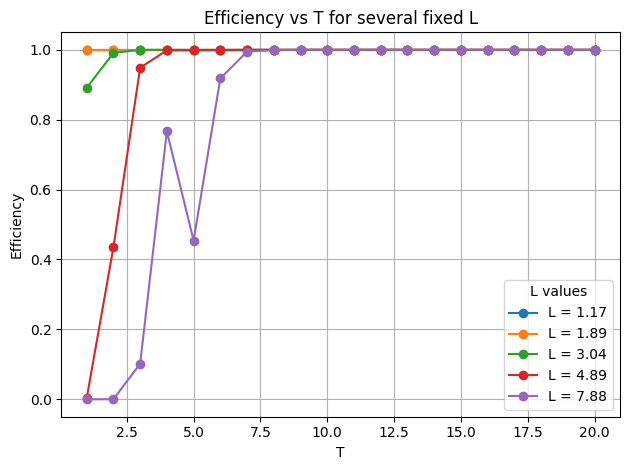

In [36]:
for i in array_entries:
    fixed_L = Ls[i]
    df_fixed_L = df_results[df_results['L'] == round(fixed_L, 6)]
    plt.plot(df_fixed_L['T'], df_fixed_L['efficiency'], marker='o', linestyle='-', label=f'L = {fixed_L:.3g}')

# plt.xscale('log')  # optional: because T was logspaced
plt.xlabel('T')
plt.ylabel('Efficiency')
plt.title('Efficiency vs T for several fixed L')
plt.grid(True)
plt.legend(title='L values')
plt.tight_layout()
plt.show()

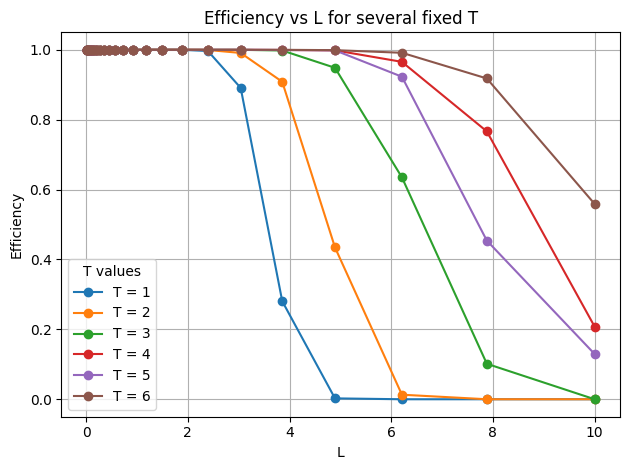

In [18]:
for i in array_entries:
    fixed_T = Ts[i]
    df_fixed_T = df_results[df_results['T'] == round(fixed_T, 6)]
    plt.plot(df_fixed_T['L'], df_fixed_T['efficiency'], marker='o', linestyle='-', label=f'T = {fixed_T:.3g}')

# plt.xscale('log')  # optional: because T was logspaced
plt.xlabel('L')
plt.ylabel('Efficiency')
plt.title('Efficiency vs L for several fixed T')
plt.grid(True)
plt.legend(title='T values')
plt.tight_layout()
plt.show()

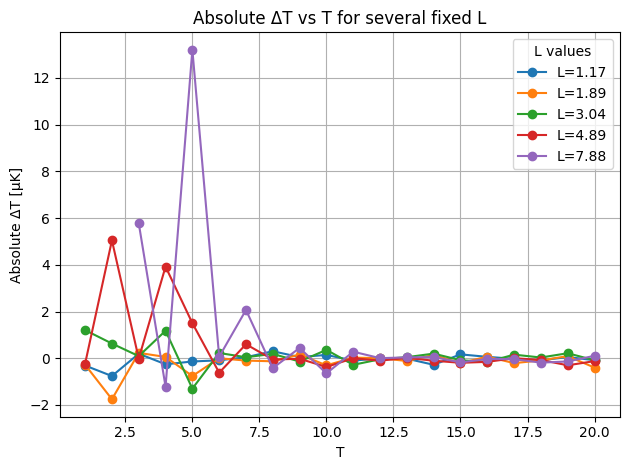

In [37]:

for i in array_entries:
    fixed_L = Ls[i]
    df_fixed_L = df_results[df_results['L'] == round(fixed_L,6)]
    plt.plot(df_fixed_L['T'], df_fixed_L['absolute_delta_T_uK'], marker='o', linestyle='-', label=f'L={fixed_L:.3g}')

# plt.xscale('log')  # T is logspaced
plt.xlabel('T')
plt.ylabel('Absolute ΔT [µK]')
plt.title('Absolute ΔT vs T for several fixed L')
plt.grid(True)
plt.legend(title='L values')
plt.tight_layout()
plt.show()


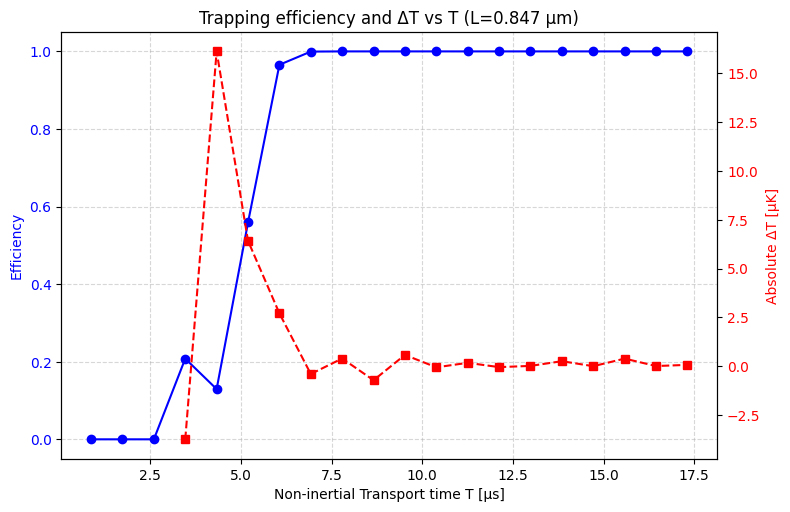

In [40]:

fixed_L = Ls[-1]  # example
df_fixed_L = df_results[df_results['L'] == round(fixed_L,6)]

fig, ax1 = plt.subplots(figsize=(8,5))

# Efficiency
ax1.plot(df_fixed_L['T']*exp.Tc*1e-3, df_fixed_L['efficiency'], 'o-', color='blue', label='Efficiency')
ax1.set_xlabel('Non-inertial Transport time T [µs]')
ax1.set_ylabel('Efficiency', color='blue')
# ax1.set_xscale('log')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True, which='both', linestyle='--', alpha=0.5)

# Temperature change on secondary y-axis
ax2 = ax1.twinx()
ax2.plot(df_fixed_L['T']*exp.Tc*1e-3, df_fixed_L['absolute_delta_T_uK'], 's--', color='red', label='ΔT [µK]')
ax2.set_ylabel('Absolute ΔT [µK]', color='red')
ax2.tick_params(axis='y', labelcolor='red')

fig.tight_layout()
plt.title(f'Trapping efficiency and ΔT vs T (L={fixed_L*exp.Lc*1e-3:.3g} µm)')
plt.show()


In [ ]:
total_transport_length = 2/(exp.Lc*1e-9) # 2 meters divided by Lc in meters (to calculate the distance in units of critical length)

total_transport_length


for L in jnp.logspace(0,6, 100):
    
    for T in jnp.logspace(1,6,100):


        dimensionless_inertial_transport_time = total_transport_length/sim.v(T/2, T, gamma, fixed_L)

        time_ns = dimensionless_inertial_transport_time*exp.Tc

        print(time_ns*1e-6)

1308.6564
2617.3127
3925.9692
5234.6255
6543.282
7851.9385
9160.596
10469.251
11777.906
13086.564
14395.221
15703.877
17012.533
18321.191
19629.846
20938.502
22247.16
23555.812
24864.47
26173.129


In [53]:
(total_transport_length / sim.v(1e3/2, 1e3, gamma, 1e3)) * exp.Tc * 1e-6



Array(13086.564, dtype=float32, weak_type=True)

In [72]:
# Create grids
L_vals = jnp.logspace(2, 4, 50)
T_vals = jnp.linspace(1, 60, 50)

# Allocate result array
time_ms = jnp.zeros((len(L_vals), len(T_vals)))


for i, L in enumerate(L_vals):
    for j, T in enumerate(T_vals):
        dimensionless_inertial_transport_time = total_transport_length / sim.v(T/2, T, gamma, L)
        # time_ms = dimensionless_inertial_transport_time *   # replace exp.Tc with correct value
        time_ms = time_ms.at[i, j].set(dimensionless_inertial_transport_time * exp.Tc * 1e-6)

In [18]:
# Create grids
L_vals = jnp.logspace(2, 2, 50)
T_vals = jnp.linspace(1, 60, 50)

# Allocate result array
# time_ms = jnp.zeros((len(L_vals), len(T_vals)))
efficiencies = jnp.zeros((len(L_vals), len(T_vals)))
final_dts = jnp.zeros((len(L_vals), len(T_vals)))
final_dts_dimensionless = jnp.zeros((len(L_vals), len(T_vals)))

for i, L in enumerate(L_vals):
    for j, T in enumerate(T_vals):
        dimensionless_inertial_transport_time = total_transport_length / sim.v(T/2, T, gamma, L)
        # time_ms = dimensionless_inertial_transport_time *   # replace exp.Tc with correct value
        time_ms = time_ms.at[i, j].set(dimensionless_inertial_transport_time * exp.Tc * 1e-6)


NameError: name 'total_transport_length' is not defined

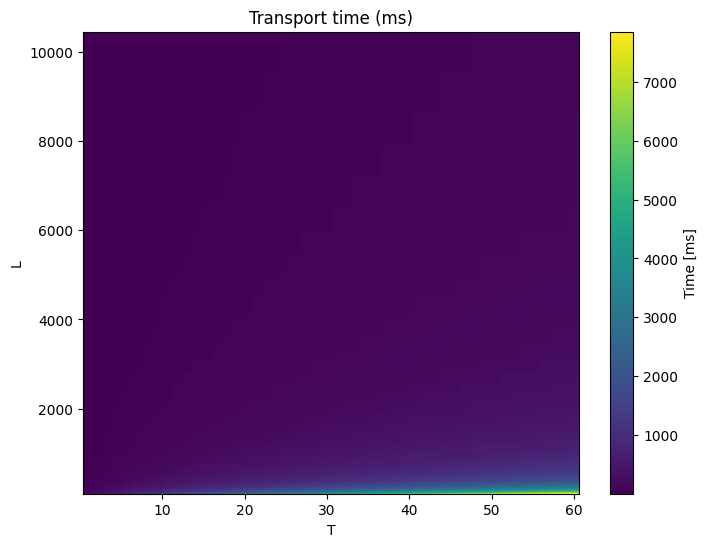

In [73]:
plt.figure(figsize=(8, 6))
plt.pcolormesh(T_vals, L_vals, time_ms, shading="auto", cmap="viridis")
plt.colorbar(label="Time [ms]")
# plt.xscale("log")
# plt.yscale("log")
plt.xlabel("T")
plt.ylabel("L")
plt.title("Transport time (ms)")
plt.show()

Clearly $a \propto \frac{L}{T^2}$ so we want to keep $T$ relative small and $L$ somwhat big. From inspecting this plot above, we can decide a region to search in parameter space. For sufficiently large $L$, we can expect good transfer velocities for low enough $T$

In [24]:
# Nice! Now I need to calculate the total transport time. For that, the idea is that, when the acceleration is 0 
# at $\tau = T/2$, it is kept at 0 for the total time needed to move it. We are just doing a rough estimate, but
# we will just calculate the total time it would take by ignoring the non-inertial times and displacement



for T in range(1,21):

    # print(sim.v(T/2, T, gamma, Ls[1]))
    # print(sim.v(T/2, T, gamma, fixed_L))

    dimensionless_inertial_transport_time = total_transport_length/sim.v(T/2, T, gamma, fixed_L)

    time_ns = dimensionless_inertial_transport_time*exp.Tc

    print(time_ns*1e-6)


# v_transport = jnp.

1.0312818e+06
2.0625636e+06
3.0938455e+06
4.1251272e+06
5.156409e+06
6.187691e+06
7.218973e+06
8.2502545e+06
9.281537e+06
1.0312818e+07
1.1344101e+07
1.2375382e+07
1.3406665e+07
1.4437946e+07
1.5469229e+07
1.6500509e+07
1.7531794e+07
1.8563074e+07
1.9594354e+07
2.0625636e+07


In [25]:
fixed_L = Ls[1]  # example
df_fixed_L = df_results[df_results['L'] == round(fixed_L,6)]


df_fixed_L['T']

20     1.000000
21     2.000000
22     3.000000
23     4.000000
24     5.000000
25     6.000000
26     7.000000
27     8.000000
28     9.000000
29    10.000000
30    11.000000
31    12.000000
32    13.000000
33    14.000000
34    15.000001
35    16.000000
36    17.000000
37    18.000000
38    19.000000
39    20.000000
Name: T, dtype: float64

In [26]:
# we save the results

import collections
import pickle

# Convert recursively
def to_regular_dict(d):
    if isinstance(d, collections.defaultdict):
        d = {k: to_regular_dict(v) for k, v in d.items()}
    elif isinstance(d, dict):
        d = {k: to_regular_dict(v) for k, v in d.items()}
    return d

results_regular = to_regular_dict(results)

# Now pickle safely
with open("results.pkl", "wb") as f:
    pickle.dump(results_regular, f)
